In [1]:
import os
import glob
import napari
import pandas as pd
import numpy as np
import mahotas as mh

from pathlib import Path
from aicsimageio import AICSImage, readers
from blimp.preprocessing.illumination_correction import IlluminationCorrection

from PIL import Image
from matplotlib import cm

data_dir = "/srv/scratch/berrylab/z3532965/operetta_cls/ARMC5_TransInhib/240322_ARMC5_TransInhib"
image_dir = os.path.join(data_dir,"240322_ARMC5_TransInhib__2024-03-26T13_50_23-Measurement 1/OME-TIFF-MIP")
label_image_dir = os.path.join(data_dir,"240322_ARMC5_TransInhib__2024-03-26T13_50_23-Measurement 1/SEGMENTATION")

ana_dir = "/srv/scratch/z3532965/src/publications/2024_ARMC5/hct116_inhibitors_IF"
illum_corr_file = os.path.join(data_dir,"240322_ARMC5_TransInhib__2024-03-26T13_50_23-Measurement 1/ILLUMCORR/illumination_correction.pkl")

23-Jul-24 23:02:08 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


In [2]:
def create_overlay_image_plot(
        channel_image, label_image,
        color='rgb(255, 191, 0)', thin=False):

    # threshold label_image and generate outlines
    label_image = np.array(label_image)
    if (thin):
        outlines = mh.labeled.borders(label_image) * 255
    else:
        outlines = mh.morph.dilate(mh.labeled.borders(label_image)) * 255
    overlay = Image.fromarray(np.uint8(outlines))
    outlines_transparent = Image.new(
        mode='RGBA', size=outlines.shape[::-1], color=(0, 0, 0, 0)
    )

    channel_image = channel_image.convert("RGBA")
    outlines_transparent.paste(channel_image, (0,0))
    outlines_transparent.paste(overlay, (0,0), mask=overlay)

    return outlines_transparent

## Load metadata
We have a csv file of the plate layout that includes information on antibody staining

In [3]:
import re

plate_layout = pd.read_csv(os.path.join(ana_dir,"METADATA","240322_ARMC5_TransInhib.csv"))
plate_layout.columns

def pad_well_names(name):
    return re.sub(r'(\D)(\d)$', r'\g<1>0\2', name)

# Apply the function to the DataFrame column in place
plate_layout['well_name'] = plate_layout['WELL'].apply(lambda x: pad_well_names(x))

## Apply illumination correction

Load illumination correction object

In [4]:
illumination_correction = IlluminationCorrection(from_file=illum_corr_file)

## Join image metadata and plate layout

In [5]:
image_metadata_files = glob.glob(os.path.join(image_dir,"*.csv"))
image_metadata = pd.concat((pd.read_csv(f) for f in image_metadata_files), ignore_index=True)
image_metadata.columns

Index(['id', 'State', 'URL', 'Row', 'Col', 'FieldID', 'TimepointID', 'FlimID',
       'ImageType', 'AcquisitionType', 'IlluminationType', 'ImageResolutionX',
       'ImageResolutionY', 'ImageSizeX', 'ImageSizeY', 'BinningX', 'BinningY',
       'MaxIntensity', 'CameraType', 'PositionX', 'PositionY',
       'MeasurementTimeOffset', 'ObjectiveMagnification', 'ObjectiveNA',
       'ExposureTime', 'OrientationMatrix', 'StandardFieldID', 'WellName',
       'AbsTime', 'NChannels', 'NPlanes'],
      dtype='object')

In [6]:
image_metadata

,id,State,URL,Row,Col,FieldID,TimepointID,FlimID,ImageType,AcquisitionType,...,MeasurementTimeOffset,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix,StandardFieldID,WellName,AbsTime,NChannels,NPlanes
0,0303K1F1P1R1,Ok,r03c03f01-fk1fl1-mip.ome.tiff,3,3,1,0,1,Signal,NipkowConfocal,...,0.0,40,1.1,0.4,"[[0.999631,0.014907,0,-85.9],[0.014976,-0.9998...",13,C03,2024-03-26 03:34:04.805499904,2,20
1,0303K1F2P1R1,Ok,r03c03f02-fk1fl1-mip.ome.tiff,3,3,2,0,1,Signal,NipkowConfocal,...,0.0,40,1.1,0.4,"[[0.999631,0.014907,0,-85.9],[0.014976,-0.9998...",1,C03,2024-03-26 03:34:15.538850048,2,20
2,0303K1F3P1R1,Ok,r03c03f03-fk1fl1-mip.ome.tiff,3,3,3,0,1,Signal,NipkowConfocal,...,0.0,40,1.1,0.4,"[[0.999631,0.014907,0,-85.9],[0.014976,-0.9998...",2,C03,2024-03-26 03:34:26.039949824,2,20
3,0303K1F4P1R1,Ok,r03c03f04-fk1fl1-mip.ome.tiff,3,3,4,0,1,Signal,NipkowConfocal,...,0.0,40,1.1,0.4,"[[0.999631,0.014907,0,-85.9],[0.014976,-0.9998...",3,C03,2024-03-26 03:34:36.381700096,2,20
4,0303K1F5P1R1,Ok,r03c03f05-fk1fl1-mip.ome.tiff,3,3,5,0,1,Signal,NipkowConfocal,...,0.0,40,1.1,0.4,"[[0.999631,0.014907,0,-85.9],[0.014976,-0.9998...",4,C03,2024-03-26 03:34:46.676400128,2,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,1314K1F21P1R1,Ok,r13c14f21-fk1fl1-mip.ome.tiff,13,14,21,0,1,Signal,NipkowConfocal,...,0.0,40,1.1,0.4,"[[0.999631,0.014907,0,-85.9],[0.014976,-0.9998...",21,M14,2024-03-26 12:24:22.516999936,2,20
3296,1314K1F22P1R1,Ok,r13c14f22-fk1fl1-mip.ome.tiff,13,14,22,0,1,Signal,NipkowConfocal,...,0.0,40,1.1,0.4,"[[0.999631,0.014907,0,-85.9],[0.014976,-0.9998...",22,M14,2024-03-26 12:24:32.776549888,2,20
3297,1314K1F23P1R1,Ok,r13c14f23-fk1fl1-mip.ome.tiff,13,14,23,0,1,Signal,NipkowConfocal,...,0.0,40,1.1,0.4,"[[0.999631,0.014907,0,-85.9],[0.014976,-0.9998...",23,M14,2024-03-26 12:24:43.445299968,2,20
3298,1314K1F24P1R1,Ok,r13c14f24-fk1fl1-mip.ome.tiff,13,14,24,0,1,Signal,NipkowConfocal,...,0.0,40,1.1,0.4,"[[0.999631,0.014907,0,-85.9],[0.014976,-0.9998...",24,M14,2024-03-26 12:24:54.127200000,2,20


In [7]:
image_metadata_annotated = image_metadata.merge(plate_layout,left_on="WellName", right_on="well_name")

In [8]:
image_metadata_annotated

,id,State,URL,Row,Col,FieldID,TimepointID,FlimID,ImageType,AcquisitionType,...,NChannels,NPlanes,WELL,CELL,SIRNA,DRUG,DRUG TIME MINUTES,PRIMARY,SECONDARY,well_name
0,0303K1F1P1R1,Ok,r03c03f01-fk1fl1-mip.ome.tiff,3,3,1,0,1,Signal,NipkowConfocal,...,2,20,C03,HCT116,ARMC5 pool,DRB 100 µM,480,Total Pol,Goat anti-mouse 568,C03
1,0303K1F2P1R1,Ok,r03c03f02-fk1fl1-mip.ome.tiff,3,3,2,0,1,Signal,NipkowConfocal,...,2,20,C03,HCT116,ARMC5 pool,DRB 100 µM,480,Total Pol,Goat anti-mouse 568,C03
2,0303K1F3P1R1,Ok,r03c03f03-fk1fl1-mip.ome.tiff,3,3,3,0,1,Signal,NipkowConfocal,...,2,20,C03,HCT116,ARMC5 pool,DRB 100 µM,480,Total Pol,Goat anti-mouse 568,C03
3,0303K1F4P1R1,Ok,r03c03f04-fk1fl1-mip.ome.tiff,3,3,4,0,1,Signal,NipkowConfocal,...,2,20,C03,HCT116,ARMC5 pool,DRB 100 µM,480,Total Pol,Goat anti-mouse 568,C03
4,0303K1F5P1R1,Ok,r03c03f05-fk1fl1-mip.ome.tiff,3,3,5,0,1,Signal,NipkowConfocal,...,2,20,C03,HCT116,ARMC5 pool,DRB 100 µM,480,Total Pol,Goat anti-mouse 568,C03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,1314K1F21P1R1,Ok,r13c14f21-fk1fl1-mip.ome.tiff,13,14,21,0,1,Signal,NipkowConfocal,...,2,20,M14,HCT116,Scramble,Vehicle,480,Total Pol,Goat anti-mouse 568,M14
3296,1314K1F22P1R1,Ok,r13c14f22-fk1fl1-mip.ome.tiff,13,14,22,0,1,Signal,NipkowConfocal,...,2,20,M14,HCT116,Scramble,Vehicle,480,Total Pol,Goat anti-mouse 568,M14
3297,1314K1F23P1R1,Ok,r13c14f23-fk1fl1-mip.ome.tiff,13,14,23,0,1,Signal,NipkowConfocal,...,2,20,M14,HCT116,Scramble,Vehicle,480,Total Pol,Goat anti-mouse 568,M14
3298,1314K1F24P1R1,Ok,r13c14f24-fk1fl1-mip.ome.tiff,13,14,24,0,1,Signal,NipkowConfocal,...,2,20,M14,HCT116,Scramble,Vehicle,480,Total Pol,Goat anti-mouse 568,M14


In [9]:
image_metadata_annotated.query(
    "CELL == 'HCT116' and SIRNA == 'ARMC5 pool' and DRUG=='DRB 100 µM' and FieldID == 1")

,id,State,URL,Row,Col,FieldID,TimepointID,FlimID,ImageType,AcquisitionType,...,NChannels,NPlanes,WELL,CELL,SIRNA,DRUG,DRUG TIME MINUTES,PRIMARY,SECONDARY,well_name
0,0303K1F1P1R1,Ok,r03c03f01-fk1fl1-mip.ome.tiff,3,3,1,0,1,Signal,NipkowConfocal,...,2,20,C03,HCT116,ARMC5 pool,DRB 100 µM,480,Total Pol,Goat anti-mouse 568,C03
300,0403K1F1P1R1,Ok,r04c03f01-fk1fl1-mip.ome.tiff,4,3,1,0,1,Signal,NipkowConfocal,...,2,20,D03,HCT116,ARMC5 pool,DRB 100 µM,240,Total Pol,Goat anti-mouse 568,D03
600,0503K1F1P1R1,Ok,r05c03f01-fk1fl1-mip.ome.tiff,5,3,1,0,1,Signal,NipkowConfocal,...,2,20,E03,HCT116,ARMC5 pool,DRB 100 µM,120,Total Pol,Goat anti-mouse 568,E03
900,0603K1F1P1R1,Ok,r06c03f01-fk1fl1-mip.ome.tiff,6,3,1,0,1,Signal,NipkowConfocal,...,2,20,F03,HCT116,ARMC5 pool,DRB 100 µM,20,Total Pol,Goat anti-mouse 568,F03
1200,0703K1F1P1R1,Ok,r07c03f01-fk1fl1-mip.ome.tiff,7,3,1,0,1,Signal,NipkowConfocal,...,2,20,G03,HCT116,ARMC5 pool,DRB 100 µM,60,Total Pol,Goat anti-mouse 568,G03
1800,0903K1F1P1R1,Ok,r09c03f01-fk1fl1-mip.ome.tiff,9,3,1,0,1,Signal,NipkowConfocal,...,2,20,I03,HCT116,ARMC5 pool,DRB 100 µM,20,Total Pol,Goat anti-mouse 568,I03
2100,1003K1F1P1R1,Ok,r10c03f01-fk1fl1-mip.ome.tiff,10,3,1,0,1,Signal,NipkowConfocal,...,2,20,J03,HCT116,ARMC5 pool,DRB 100 µM,60,Total Pol,Goat anti-mouse 568,J03
2400,1103K1F1P1R1,Ok,r11c03f01-fk1fl1-mip.ome.tiff,11,3,1,0,1,Signal,NipkowConfocal,...,2,20,K03,HCT116,ARMC5 pool,DRB 100 µM,120,Total Pol,Goat anti-mouse 568,K03
2700,1203K1F1P1R1,Ok,r12c03f01-fk1fl1-mip.ome.tiff,12,3,1,0,1,Signal,NipkowConfocal,...,2,20,L03,HCT116,ARMC5 pool,DRB 100 µM,240,Total Pol,Goat anti-mouse 568,L03
3000,1303K1F1P1R1,Ok,r13c03f01-fk1fl1-mip.ome.tiff,13,3,1,0,1,Signal,NipkowConfocal,...,2,20,M03,HCT116,ARMC5 pool,DRB 100 µM,480,Total Pol,Goat anti-mouse 568,M03


## Save Examples

In [32]:
example_images = image_metadata_annotated.query("FieldID == 4 & PRIMARY!='No primary'")[['URL','PRIMARY','SECONDARY','CELL','SIRNA','WellName','DRUG','DRUG TIME MINUTES']]
example_images['new_filename'] = example_images['SIRNA'] + '_' + example_images['PRIMARY'] + '_' + example_images['SECONDARY'] + '_' + example_images['DRUG'] + '_' + example_images['DRUG TIME MINUTES'].apply(str) + '_' + example_images['WellName'] + '.png'
example_images['new_filename_overlay'] = example_images['SIRNA'] + '_' + example_images['PRIMARY'] + '_' + example_images['SECONDARY'] + '_' + example_images['DRUG'] + '_' + example_images['DRUG TIME MINUTES'].apply(str) + '_' + example_images['WellName'] + '_nuclei.png'
example_images['filename_segmentation'] = 'nuclei_' + example_images['URL']
example_images['intensity_rescaling_group'] = example_images['PRIMARY']

In [33]:
from pathlib import Path
example_dir = Path(image_dir).parent / 'EXAMPLES' / 'RGB'
example_overlay_dir = Path(image_dir).parent / 'EXAMPLES' / 'RGB_OVERLAY'
if not example_dir.exists(): 
    example_dir.mkdir(parents=True)
if not example_overlay_dir.exists(): 
    example_overlay_dir.mkdir(parents=True)

In [34]:
%%capture
example_images_grouped = example_images.query("SIRNA == 'ARMC5 pool' & `DRUG` == '0' ").groupby('intensity_rescaling_group')
upper_rescale_values = {}
for group_name, group_data in example_images_grouped:
    group_of_image_files = group_data['URL'].to_list()
    upper_rescale_value = []
    for image_filename in group_of_image_files:
        aics_image = AICSImage(Path(image_dir) / image_filename, reader=readers.ome_tiff_reader.OmeTiffReader )
        aics_image = illumination_correction.correct(aics_image)
        IF_array = aics_image.get_image_data('YX',Z=0,C=0,T=0)
        upper_rescale_value.append(np.quantile(IF_array,0.99))
    upper_rescale_values[group_name] = max(upper_rescale_value)

In [35]:
upper_rescale_values_df = pd.DataFrame(upper_rescale_values.items(), columns=['intensity_rescaling_group','upper_rescale_value'])
upper_rescale_values_df
example_images = example_images.merge(upper_rescale_values_df,on="intensity_rescaling_group")

In [36]:
upper_rescale_values_df

,intensity_rescaling_group,upper_rescale_value
0,Total Pol,300.0


In [37]:
%%capture
for index, row in example_images.iterrows():
    aics_image = AICSImage(Path(image_dir) / row["URL"], reader=readers.ome_tiff_reader.OmeTiffReader)
    aics_image = illumination_correction.correct(aics_image)
    IF_array = aics_image.get_image_data('YX',Z=0,C=0,T=0)
    lower_rescale_value = 120
    IF_array_rescaled = (IF_array.astype(float) - lower_rescale_value) / row["upper_rescale_value"]
    pil_image = Image.fromarray(cm.magma(IF_array_rescaled.clip(0,1),bytes=True)).convert('RGB')
    pil_image.save(str(example_dir / row["new_filename"]), quality=85, subsampling=0)
    
    # add segmentation overlay
    segmentation_aics_image = AICSImage(Path(label_image_dir) / row["filename_segmentation"], reader=readers.ome_tiff_reader.OmeTiffReader)
    segmentation_array = segmentation_aics_image.get_image_data('YX',Z=0,C=0,T=0) # already cropped
    segmentation_pil_image = Image.fromarray(segmentation_array)
    overlay_image = create_overlay_image_plot(pil_image,segmentation_pil_image,thin=True)
    overlay_image.save(str(example_overlay_dir / row["new_filename_overlay"]), quality=85, subsampling=0)

In [38]:
corresponding_secondaries = upper_rescale_values_df.merge(
    image_metadata_annotated.drop_duplicates(['PRIMARY','SECONDARY'])[['PRIMARY','SECONDARY']],
    left_on='intensity_rescaling_group',right_on='PRIMARY').drop('PRIMARY',axis=1)
corresponding_secondaries

,intensity_rescaling_group,upper_rescale_value,SECONDARY
0,Total Pol,300.0,Goat anti-mouse 568


In [39]:
secondary_only = image_metadata_annotated.query("FieldID == 4 & PRIMARY=='No primary' ")[['URL','PRIMARY','SECONDARY','CELL','SIRNA','WellName']].merge(
    corresponding_secondaries,
    left_on='SECONDARY',
    right_on='SECONDARY')
secondary_only['new_filename'] = secondary_only['SIRNA'] + '_' + secondary_only['PRIMARY'] + '_' + secondary_only['SECONDARY'] + '_' + secondary_only['WellName'] + '_rescaled_for_' + secondary_only['intensity_rescaling_group'] + '.png'
secondary_only['new_filename_overlay'] = secondary_only['SIRNA'] + '_' + secondary_only['PRIMARY'] + '_' + secondary_only['SECONDARY'] + '_' + secondary_only['WellName'] + '_rescaled_for_' + secondary_only['intensity_rescaling_group'] + '_nuclei.png'
secondary_only

,URL,PRIMARY,SECONDARY,CELL,SIRNA,WellName,intensity_rescaling_group,upper_rescale_value,new_filename,new_filename_overlay
0,r08c03f04-fk1fl1-mip.ome.tiff,No primary,Goat anti-mouse 568,HCT116,ARMC5 pool,H03,Total Pol,300.0,ARMC5 pool_No primary_Goat anti-mouse 568_H03_...,ARMC5 pool_No primary_Goat anti-mouse 568_H03_...
1,r08c05f04-fk1fl1-mip.ome.tiff,No primary,Goat anti-mouse 568,HCT116,ARMC5 pool,H05,Total Pol,300.0,ARMC5 pool_No primary_Goat anti-mouse 568_H05_...,ARMC5 pool_No primary_Goat anti-mouse 568_H05_...
2,r08c07f04-fk1fl1-mip.ome.tiff,No primary,Goat anti-mouse 568,HCT116,ARMC5 pool,H07,Total Pol,300.0,ARMC5 pool_No primary_Goat anti-mouse 568_H07_...,ARMC5 pool_No primary_Goat anti-mouse 568_H07_...
3,r08c09f04-fk1fl1-mip.ome.tiff,No primary,Goat anti-mouse 568,HCT116,Scramble,H09,Total Pol,300.0,Scramble_No primary_Goat anti-mouse 568_H09_re...,Scramble_No primary_Goat anti-mouse 568_H09_re...
4,r08c11f04-fk1fl1-mip.ome.tiff,No primary,Goat anti-mouse 568,HCT116,Scramble,H11,Total Pol,300.0,Scramble_No primary_Goat anti-mouse 568_H11_re...,Scramble_No primary_Goat anti-mouse 568_H11_re...
5,r08c13f04-fk1fl1-mip.ome.tiff,No primary,Goat anti-mouse 568,HCT116,Scramble,H13,Total Pol,300.0,Scramble_No primary_Goat anti-mouse 568_H13_re...,Scramble_No primary_Goat anti-mouse 568_H13_re...


In [40]:
%%capture
for index, row in secondary_only.iterrows():
    aics_image = AICSImage(Path(image_dir) / row["URL"], reader=readers.ome_tiff_reader.OmeTiffReader)
    aics_image = illumination_correction.correct(aics_image)
    IF_array = aics_image.get_image_data('YX',Z=0,C=0,T=0)
    lower_rescale_value = 147
    IF_array_rescaled = (IF_array.astype(float) - lower_rescale_value) / row["upper_rescale_value"]
    pil_image = Image.fromarray(cm.magma(IF_array_rescaled.clip(0,1),bytes=True)).convert('RGB')
    pil_image.save(str(example_dir / row["new_filename"]), quality=85, subsampling=0)
    
    # add segmentation overlay
    segmentation_aics_image = AICSImage(Path(label_image_dir) / row["filename_segmentation"], reader=readers.ome_tiff_reader.OmeTiffReader)
    segmentation_array = segmentation_aics_image.get_image_data('YX',Z=0,C=0,T=0)
    segmentation_pil_image = Image.fromarray(segmentation_array)
    overlay_image = create_overlay_image_plot(pil_image,segmentation_pil_image,thin=True)
    overlay_image.save(str(example_overlay_dir / row["new_filename_overlay"]), quality=85, subsampling=0)

KeyError: 'filename_segmentation'

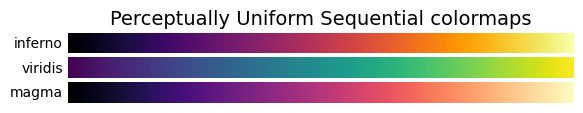

In [41]:
import matplotlib.pyplot as plt
import numpy as np

cmaps = [('Perceptually Uniform Sequential', [
            'viridis', 'plasma', 'inferno', 'magma', 'cividis']),
         ('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
         ('Sequential (2)', [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']),
         ('Diverging', [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
         ('Cyclic', ['twilight', 'twilight_shifted', 'hsv']),
         ('Qualitative', [
            'Pastel1', 'Pastel2', 'Paired', 'Accent',
            'Dark2', 'Set1', 'Set2', 'Set3',
            'tab10', 'tab20', 'tab20b', 'tab20c']),
         ('Miscellaneous', [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral',
            'gist_ncar'])]

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

def plot_color_gradients(cmap_category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows-1)*0.1)*0.22
    fig, axs = plt.subplots(nrows=nrows, figsize=(6.4, figh))
    fig.subplots_adjust(top=1-.35/figh, bottom=.15/figh, left=0.2, right=0.99)

    axs[0].set_title(f"{cmap_category} colormaps", fontsize=14)

    for ax, cmap_name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=cmap_name)
        ax.text(-.01, .5, cmap_name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()
        
    return fig


colormaps = plot_color_gradients('Perceptually Uniform Sequential', ['inferno','viridis','magma'])

colormaps.savefig(str(Path(image_dir).parent / 'EXAMPLES' / 'colormap.png'))

In [42]:
example_dir

PosixPath('/srv/scratch/berrylab/z3532965/operetta_cls/ARMC5_TransInhib/240322_ARMC5_TransInhib/240322_ARMC5_TransInhib__2024-03-26T13_50_23-Measurement 1/EXAMPLES/RGB')

In [43]:
aics_image.channel_names

['Alexa 568', 'DAPI']